# Start

In [1]:
pip install tabulate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install scikeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# imports
from tabulate import tabulate
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
import pickle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout


## Loading the data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/.pkl_data/final_train_data.pkl'

df_train = pd.read_pickle(file_path)
train_df = pd.DataFrame(df_train)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path = '/content/drive/MyDrive/.pkl_data/final_test_data.pkl'

df_test = pd.read_pickle(file_path)
test_df = pd.DataFrame(df_test)

In [6]:
WIDTH = 200
HEIGHT = 250

X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values



In [7]:
batch_size = 1000

# Scale the images in batches for X_train
for i in range(0, len(X_train), batch_size):
    X_train[i:i+batch_size] = X_train[i:i+batch_size] / 255.0

# Scale the images in batches for X_test
for i in range(0, len(X_test), batch_size):
    X_test[i:i+batch_size] = X_test[i:i+batch_size] / 255.0


In [8]:
X_train = X_train.reshape((-1, HEIGHT, WIDTH, 3))  # 3 channels for RGB
X_test = X_test.reshape((-1, HEIGHT, WIDTH, 3))  # 3 channels for RGB

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=23)

NUM_CLASSES = len(set(y_train))
NUM_NEURONS = 1000

# Mapping

In [9]:
class LabelMapper(BaseEstimator, TransformerMixin):
    def __init__(self, pandas_series=True):
        self.pandas_series = pandas_series

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.pandas_series:
            return X.map(self.map_labels)
        else:
            return np.array([self.map_labels(x) for x in X])

    @staticmethod
    def map_labels(original_label):
        if original_label in [0, 4, 5, 6]:
            return 0  # scooter
        elif original_label == 1:
            return 1  # not a scooter
        elif original_label in [2, 3]:
            return 2  # picture not clear
        else:
            return None  # handle cases outside your defined labels, if any


In [10]:
##mapping_pipeline = Pipeline([
##    ('mapper', LabelMapper(pandas_series=False)),  # If labels are not pandas Series, set pandas_series=False
##])


#####Transform the labels for each set

y_train_mapped = y_train
y_val_mapped = y_val
y_test_mapped = y_test

# Modeling

## Dummy Classifier

In [11]:
# Create a pipeline
dummy_pipeline = Pipeline([
    ('classifier', DummyClassifier(strategy='most_frequent')),  # Always predict the most frequent class
])

# Train the dummy classifier
dummy_pipeline.fit(X_train, y_train_mapped)

# Evaluate the dummy classifier
y_val_pred_dummy = dummy_pipeline.predict(X_val)
accuracy_dummy = accuracy_score(y_val_mapped, y_val_pred_dummy)
precision_dummy = precision_score(y_val_mapped, y_val_pred_dummy, average='weighted')
recall_dummy = recall_score(y_val_mapped, y_val_pred_dummy, average='weighted')
f1_dummy = f1_score(y_val_mapped, y_val_pred_dummy, average='weighted')

print("Dummy Classifier Metrics:")
print(f"Accuracy: {accuracy_dummy}")
print(f"Precision: {precision_dummy}")
print(f"Recall: {recall_dummy}")
print(f"F1-Score: {f1_dummy}")

Dummy Classifier Metrics:
Accuracy: 0.35071090047393366
Precision: 0.12299813571123738
Recall: 0.35071090047393366
F1-Score: 0.18212355533383218


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Checking for missing values in train, validation, and test sets
datasets = {'train': (X_train, y_train), 'validation': (X_val, y_val), 'test': (X_test, y_test)}
for name, (X, y) in datasets.items():
    print(f'Checking missing values in {name} set:')
    print(f'Features: Contains NaN values - {np.isnan(X).any()}')
    print(f'Labels: Contains NaN values - {np.isnan(y).any()}\n')


Checking missing values in train set:
Features: Contains NaN values - False
Labels: Contains NaN values - False

Checking missing values in validation set:
Features: Contains NaN values - False
Labels: Contains NaN values - False

Checking missing values in test set:
Features: Contains NaN values - False
Labels: Contains NaN values - False



## simple NN

In [13]:
class SimpleNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(SimpleNN, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(NUM_NEURONS, activation='relu')
        self.d2 = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)



In [14]:
def create_simple_nn():
    model = Sequential([
        Flatten(input_shape=(HEIGHT, WIDTH, 3)),
        Dense(NUM_NEURONS, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    return model, early_stopping

In [15]:
# Create the simple convolutional neural network model
model, early_stopping = create_simple_nn()

# Train the model
history = model.fit(X_train, y_train_mapped, batch_size=4, epochs=10, validation_data=(X_val, y_val_mapped), callbacks=[early_stopping])


Epoch 1/10
2373/2373 [==============================] - 81s 32ms/step - loss: nan - accuracy: 0.2853 - val_loss: nan - val_accuracy: 0.2768
Epoch 2/10
2373/2373 [==============================] - 72s 30ms/step - loss: nan - accuracy: 0.2853 - val_loss: nan - val_accuracy: 0.2768
Epoch 3/10
2373/2373 [==============================] - 71s 30ms/step - loss: nan - accuracy: 0.2853 - val_loss: nan - val_accuracy: 0.2768
Epoch 4/10
2373/2373 [==============================] - 75s 31ms/step - loss: nan - accuracy: 0.2853 - val_loss: nan - val_accuracy: 0.2768


33/33 [==============================] - 0s 9ms/step

Simple NN Val Metrics:
Accuracy: 0.27677725118483415
Precision: 0.07660564677343276
Recall: 0.27677725118483415
F1-Score: 0.11999845188711444
              precision    recall  f1-score   support

           0       0.28      1.00      0.43       292
           1       0.00      0.00      0.00       370
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00       164
           5       0.00      0.00      0.00       228

    accuracy                           0.28      1055
   macro avg       0.06      0.20      0.09      1055
weighted avg       0.08      0.28      0.12      1055



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

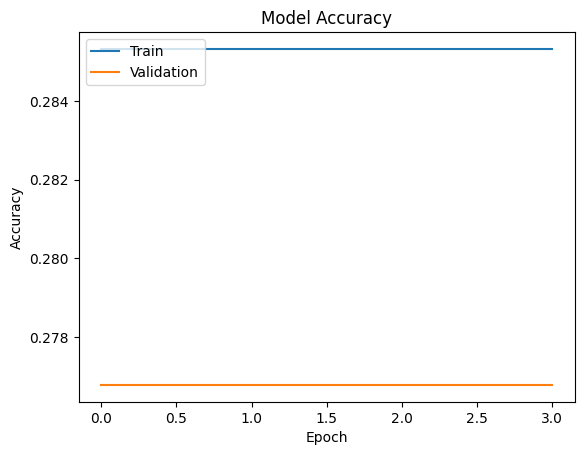

In [20]:
# Evaluate the model
y_val_pred_probs = model.predict(X_val)
y_val_pred_nn = np.argmax(y_val_pred_probs, axis=1)
accuracy = accuracy_score(y_val_mapped, y_val_pred_nn)
precision = precision_score(y_val_mapped, y_val_pred_nn, average='weighted')
recall = recall_score(y_val_mapped, y_val_pred_nn, average='weighted')
f1 = f1_score(y_val_mapped, y_val_pred_nn, average='weighted')
classification = classification_report(y_val_mapped, y_val_pred_nn)

print("\nSimple NN Val Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(classification)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# Test set predictions
y_test_pred_probs = model.predict(X_test)
y_test_pred_nn = np.argmax(y_test_pred_probs, axis=1)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred_nn)
test_precision = precision_score(y_test, y_test_pred_nn, average='weighted')
test_recall = recall_score(y_test, y_test_pred_nn, average='weighted')
test_f1 = f1_score(y_test, y_test_pred_nn, average='weighted')

142/142 [==============================] - 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
models = ['Dummy Classifier', 'Simple Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

dummy_results = [accuracy_dummy, precision_dummy, recall_dummy, f1_dummy]
nn_results_test = [test_accuracy, test_precision, test_recall, test_f1]

results = [
    ['Dummy Classifier'] + dummy_results,
    ['Simple Neural Network'] + nn_results_test
]

headers = ['Models'] + metrics
best_metrics = [max(dummy_results[i], nn_results_test[i]) for i in range(len(dummy_results))]



for row in results:
    for i, value in enumerate(row[1:], start=1):  # Exclude the model name and start from index 1
        if value == best_metrics[i-1]:  # Use i-1 as the index for best_metrics
            row[i] = f"\033[1m{value:.4f}\033[0m"  # Use ANSI escape sequences for bold text
        else:
            row[i] = f"{value:.4f}"

# Print the table
print(tabulate(results, headers=headers, tablefmt='github'))


| Models                |   Accuracy |   Precision |   Recall |   F1-Score |
|-----------------------|------------|-------------|----------|------------|
| Dummy Classifier      |     0.3507 |      0.123  |   0.3507 |     0.1821 |
| Simple Neural Network |     0.2746 |      0.0754 |   0.2746 |     0.1183 |
